# Instalação

In [ ]:
!pip install trimesh
!pip install open3d

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
q1_dir = '/content/drive/My Drive/KITTI-Sequence'
q2_dir = '/content/drive/My Drive/img_dtlabs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Questão 1


## Depedencias

In [ ]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import os
import random
import torch
import open3d as o3d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Fluxo de Resposta ao problema

In [ ]:
# def extract_keypoints(points, voxel_size):
#     cloud = trimesh.points.PointCloud(points)
#     cloud = cloud.voxelized(voxel_size)
#     return cloud.points

def extract_keypoints(points, num_keypoints):
    if points.shape[0] > num_keypoints:
        indices = np.random.choice(points.shape[0], num_keypoints, replace=False)
        return points[indices]
    return points

In [ ]:
def remove_outliers(points, threshold=1.5):
    mean = np.mean(points, axis=0)
    dist = np.linalg.norm(points - mean, axis=1)
    return points[dist < threshold * np.std(dist)]


In [ ]:
def load_point_cloud(file_path):
    mesh = trimesh.load(file_path)
    return np.array(mesh.vertices)

In [ ]:
def voxel_downsample(points, voxel_size):
    voxel_grid = np.floor(points / voxel_size).astype(np.int32)
    unique_voxels, indices = np.unique(voxel_grid, axis=0, return_index=True)
    return points[indices]


In [ ]:
def load_all_point_clouds(q1_dir):
    point_clouds = []

    for root, dirs, files in os.walk(q1_dir):
        for file in files:
            if file.endswith('.obj'):
                file_path = os.path.join(root, file)
                print(f"Carregando arquivo: {file_path}")
                point_cloud = load_point_cloud(file_path)
                point_clouds.append(point_cloud)

    return point_clouds

In [ ]:
def closest_point(src, dst):
    distances = torch.cdist(src, dst)
    indices = torch.argmin(distances, dim=1)
    return indices


In [ ]:
def estimate_rigid_transform(A, B):
    centroid_A = torch.mean(A, dim=0)
    centroid_B = torch.mean(B, dim=0)

    H = (A - centroid_A).T @ (B - centroid_B)
    U, S, Vt = torch.svd(H)
    R = Vt @ U.T

    if torch.det(R) < 0:
        Vt[:, -1] *= -1
        R = Vt @ U.T

    t = centroid_B - R @ centroid_A
    return R, t

In [ ]:
def icp(src, dst, max_iterations=100, tolerance=1e-6):
    if src.shape[0] > dst.shape[0]:
        src = src[np.random.choice(src.shape[0], dst.shape[0], replace=False)]
    elif dst.shape[0] > src.shape[0]:
        dst = dst[np.random.choice(dst.shape[0], src.shape[0], replace=False)]

    src_homogeneous = np.ones((src.shape[0], 4))
    src_homogeneous[:, :-1] = src
    T = np.eye(4)
    prev_error = float('inf')

    for i in range(max_iterations):
        indices = closest_point(src_homogeneous[:, :-1], dst)
        matched_src = src_homogeneous[:, :-1][indices]

        R, t = estimate_rigid_transform(matched_src, dst)

        src_homogeneous[:, :-1] = (R @ src_homogeneous[:, :-1].T).T + t

        error = np.mean(np.linalg.norm(src_homogeneous[:, :-1] - dst, axis=1))
        if abs(prev_error - error) < tolerance:
            break
        prev_error = error

    return T


def icp_with_voxel(src, dst, max_iterations=200, tolerance=1e-6):
    src = voxel_downsample(src, 0.2)  # Ajuste o valor do voxel_size conforme necessário
    dst = voxel_downsample(dst, 0.2)

    # Garantir que as nuvens subamostradas tenham o mesmo número de pontos
    min_points = min(src.shape[0], dst.shape[0])
    src = src[:min_points]
    dst = dst[:min_points]

    src_homogeneous = np.ones((src.shape[0], 4))
    src_homogeneous[:, :-1] = src

    T = np.eye(4)
    prev_error = float('inf')

    # Construir a árvore KD apenas uma vez
    tree = KDTree(dst)

    for i in range(max_iterations):
        distances, indices = tree.query(src_homogeneous[:, :-1])

        # Corrigindo os índices para garantir que não ultrapassem o tamanho do array
        indices = np.clip(indices, 0, dst.shape[0] - 1)

        matched_src = src_homogeneous[:, :-1][indices]

        R, t = estimate_rigid_transform(matched_src, dst)

        src_homogeneous[:, :-1] = (R @ src_homogeneous[:, :-1].T).T + t

        error = np.mean(np.linalg.norm(src_homogeneous[:, :-1] - dst, axis=1))
        if abs(prev_error - error) < tolerance:
            break
        prev_error = error

    return T

def icp_torch(src, dst, max_iterations=300, tolerance=1e-6):

    #src = extract_keypoints(src, 500)  # Extrair 500 keypoints
    #dst = extract_keypoints(dst, 500)

    src = torch.tensor(src, dtype=torch.float32, device=device)
    dst = torch.tensor(dst, dtype=torch.float32, device=device)

    for i in range(max_iterations):
        indices = closest_point(src, dst)
        matched_dst = dst[indices]

        R, t = estimate_rigid_transform(src, matched_dst)
        src = (R @ src.T).T + t

        error = torch.mean(torch.norm(src - matched_dst, dim=1))
        if error < tolerance:
            break

        # Limpar a memória da GPU
        torch.cuda.empty_cache()

    return R.cpu().numpy(), t.cpu().numpy()

In [ ]:
# def estimate_trajectory(scans):
#     trajectory = [np.eye(4)]  # A trajetória começa com a identidade (ponto inicial)

#     for i in range(1, len(scans)):
#         T = icp(scans[i-1], scans[i])
#         trajectory.append(trajectory[-1] @ T)

#     return np.array(trajectory)

# def estimate_trajectory(scans):
#     trajectory = [np.eye(4)]
#     for i in range(1, len(scans)):
#         R, t = icp_torch(scans[i-1], scans[i])
#         T = np.eye(4)
#         T[:3, :3] = R
#         T[:3, 3] = t
#         trajectory.append(trajectory[-1] @ T)
#     return np.array(trajectory)

def estimate_trajectory(scans):
    trajectory = [np.eye(4)]
    for i in range(1, len(scans)):
        src = voxel_downsample(scans[i-1], 0.3)
        dst = voxel_downsample(scans[i], 0.3)

        R, t = icp_torch(src, dst)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        trajectory.append(trajectory[-1] @ T)
    return np.array(trajectory)

In [ ]:
def compare_with_ground_truth(estimated_trajectory, ground_truth):
    error = np.linalg.norm(estimated_trajectory - ground_truth, axis=(1, 2))
    print("Erro médio: ", np.mean(error))
    return error

In [ ]:
def plot_trajectory(trajectory):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extraindo as coordenadas (x, y, z)
    x = trajectory[:, 0, 3]
    y = trajectory[:, 1, 3]
    z = trajectory[:, 2, 3]

    ax.plot(x, y, z, label='Trajectory')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Comparar com a Implementacao usual

In [ ]:
def calculate_ground_truth_trajectory(scans):
    trajectory = [np.eye(4)]  # Começa com a identidade

    pcd_prev = o3d.geometry.PointCloud()
    pcd_prev.points = o3d.utility.Vector3dVector(scans[0])

    for i in range(1, len(scans)):
        pcd_curr = o3d.geometry.PointCloud()
        pcd_curr.points = o3d.utility.Vector3dVector(scans[i])

        reg_icp = o3d.pipelines.registration.registration_icp(
            pcd_curr, pcd_prev,
            max_correspondence_distance=0.2,
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )

        T = reg_icp.transformation
        trajectory.append(trajectory[-1] @ T)

        pcd_prev = pcd_curr

    return np.array(trajectory)


In [ ]:
def plot_comparison(estimated, reference):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Trajetória estimada
    ax.plot(estimated[:, 0, 3], estimated[:, 1, 3], estimated[:, 2, 3], label='Trajectory Estimada', color='blue')

    # Trajetória de referência
    ax.plot(reference[:, 0, 3], reference[:, 1, 3], reference[:, 2, 3], label='Trajectory de Referência', color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

In [ ]:
def compare_trajectories(estimated, reference):
    error = np.linalg.norm(estimated - reference, axis=(1, 2))
    mean_error = np.mean(error)
    print("Erro médio em comparação com a open3d: ", mean_error)
    return error

## Execução

Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000004/000004_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000021/000021_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000019/000019_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000026/000026_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000010/000010_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000028/000028_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000005/000005_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000003/000003_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000002/000002_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000017/000017_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000008/000008_points.obj
Carregando arquivo: /content/drive/My Drive/KITTI-Sequence/000011/000011_poi

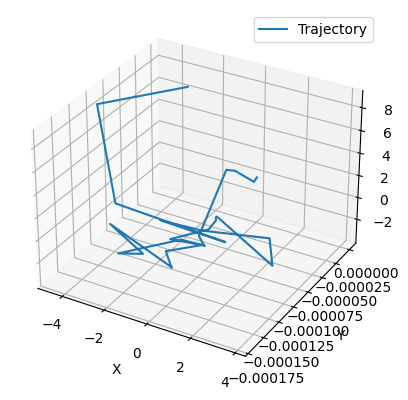

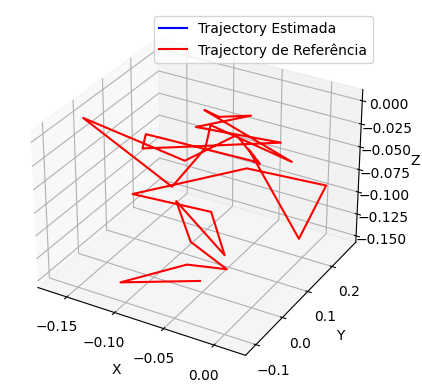

In [ ]:
# Carregando ground-truth (certifique-se de ter o arquivo 'ground_truth.npy' no mesmo diretório ou ajuste o caminho)
ground_truth = np.load('/content/drive/My Drive/ground_truth.npy')

# Carregando todos os arquivos .obj recursivamente dos subdiretórios
scans = load_all_point_clouds(q1_dir)

# Estimando a trajetória
estimated_trajectory = estimate_trajectory(scans)
reference_trajectory = calculate_ground_truth_trajectory(scans)

# Comparando com a ground-truth
compare_with_ground_truth(estimated_trajectory, ground_truth)

compare_trajectories(estimated_trajectory, reference_trajectory)

# Plotando a trajetória
plot_trajectory(estimated_trajectory)
plot_comparison(estimated_trajectory, reference_trajectory)

# Questão 2

# Dependencias

In [69]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Lambda, Input
from tensorflow.keras import backend as K
import numpy as np
import cv2
import os
import pandas as pd

In [ ]:
zip_file = '/content/drive/My Drive/post-processed.zip'
extract_dir = '/content/drive/My Drive/img_dtlabs'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Arquivo ZIP extraído com sucesso!")

Arquivo ZIP extraído com sucesso!


In [70]:
def load_images_and_labels(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (shape, shape))
                    images.append(img)
                    # Supondo que o nome do diretório é a classe
                    label = os.path.basename(root)
                    labels.append(label)
                else:
                    print(f"Erro ao carregar a imagem: {img_path}")

    print(labels)
    return np.array(images), np.array(labels)


In [74]:
images, labels = load_images_and_labels(extract_dir)

images = images / 255.0

unique_labels = np.unique(labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels])

train_images, test_images, train_labels, test_labels = train_test_split(images, mapped_labels, test_size=0.2, random_state=42)

num_classes = len(unique_labels)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


['AJ_Lamas', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Eckhart', 'Aaron_Eckhart', 'Aaron_Eckhart', 'Aaron_Eckhart', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Guiel', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Aaron_Sorkin', 'Aaron_Sorkin', 'Aaron_Sorkin', 'Aaron_Tippin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Aziz_Al-Hakim', 'Abdel_Nasser_Assidi', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abdullah_Gul', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abid_Hamid_Mahmud_Al-Tik

In [75]:
descriptor_size = 128
shape = 50
activation = 'relu6'

# Definindo o modelo
model = Sequential()
model.add(Input(shape=(shape, shape, 3)))
model.add(Conv2D(16, kernel_size=(3, 3), activation=activation))
model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(descriptor_size))
model.add(Lambda(lambda x: K.l2_normalize(x, axis=-1)))
model.compile(optimizer='Adam', loss='mse')
model.fit(train_images, train_images, epochs=10, batch_size=32, validation_data=(test_images, test_images))

Epoch 1/10


ValueError: Dimensions must be equal, but are 50 and 32 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, sequential_4_1/lambda_3_1/l2_normalize)' with input shapes: [32,50,50,3], [32,128].

In [ ]:
def get_descriptor(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (shape, shape))
    img = np.expand_dims(img, axis=0) / 255.0
    descriptor = model.predict(img)
    return descriptor

In [ ]:
database = {}

def add_to_database(name, image_path):
    descriptor = get_descriptor(image_path)
    database[name] = descriptor

In [ ]:
def recognize_face(test_image_path):
    test_descriptor = get_descriptor(test_image_path)
    closest_name = None
    closest_distance = float('inf')

    for name, descriptor in database.items():
        distance = np.linalg.norm(test_descriptor - descriptor)
        if distance < closest_distance:
            closest_distance = distance
            closest_name = name

    return closest_name, closest_distance

In [ ]:
add_to_database('celebrity_1', 'path/to/celebrity_1_image.jpg')
add_to_database('celebrity_2', 'path/to/celebrity_2_image.jpg')

recognized_name, score = recognize_face('path/to/image_with_mask.jpg')
print(f'Pessoa reconhecida: {recognized_name}, Score: {score}')

infer_image = cv2.imread('path/to/image_with_mask.jpg')
cv2.imshow('Imagem para Inferência', infer_image)
cv2.waitKey(0)
cv2.destroyAllWindows()